Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/cho/.cache/torch/hub/v0.10.0.zip
/Users/cho/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cho/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /Users/cho/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/cho/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/cho/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/cho/.cache/torch/hub/pytorch_vision_v0.10.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

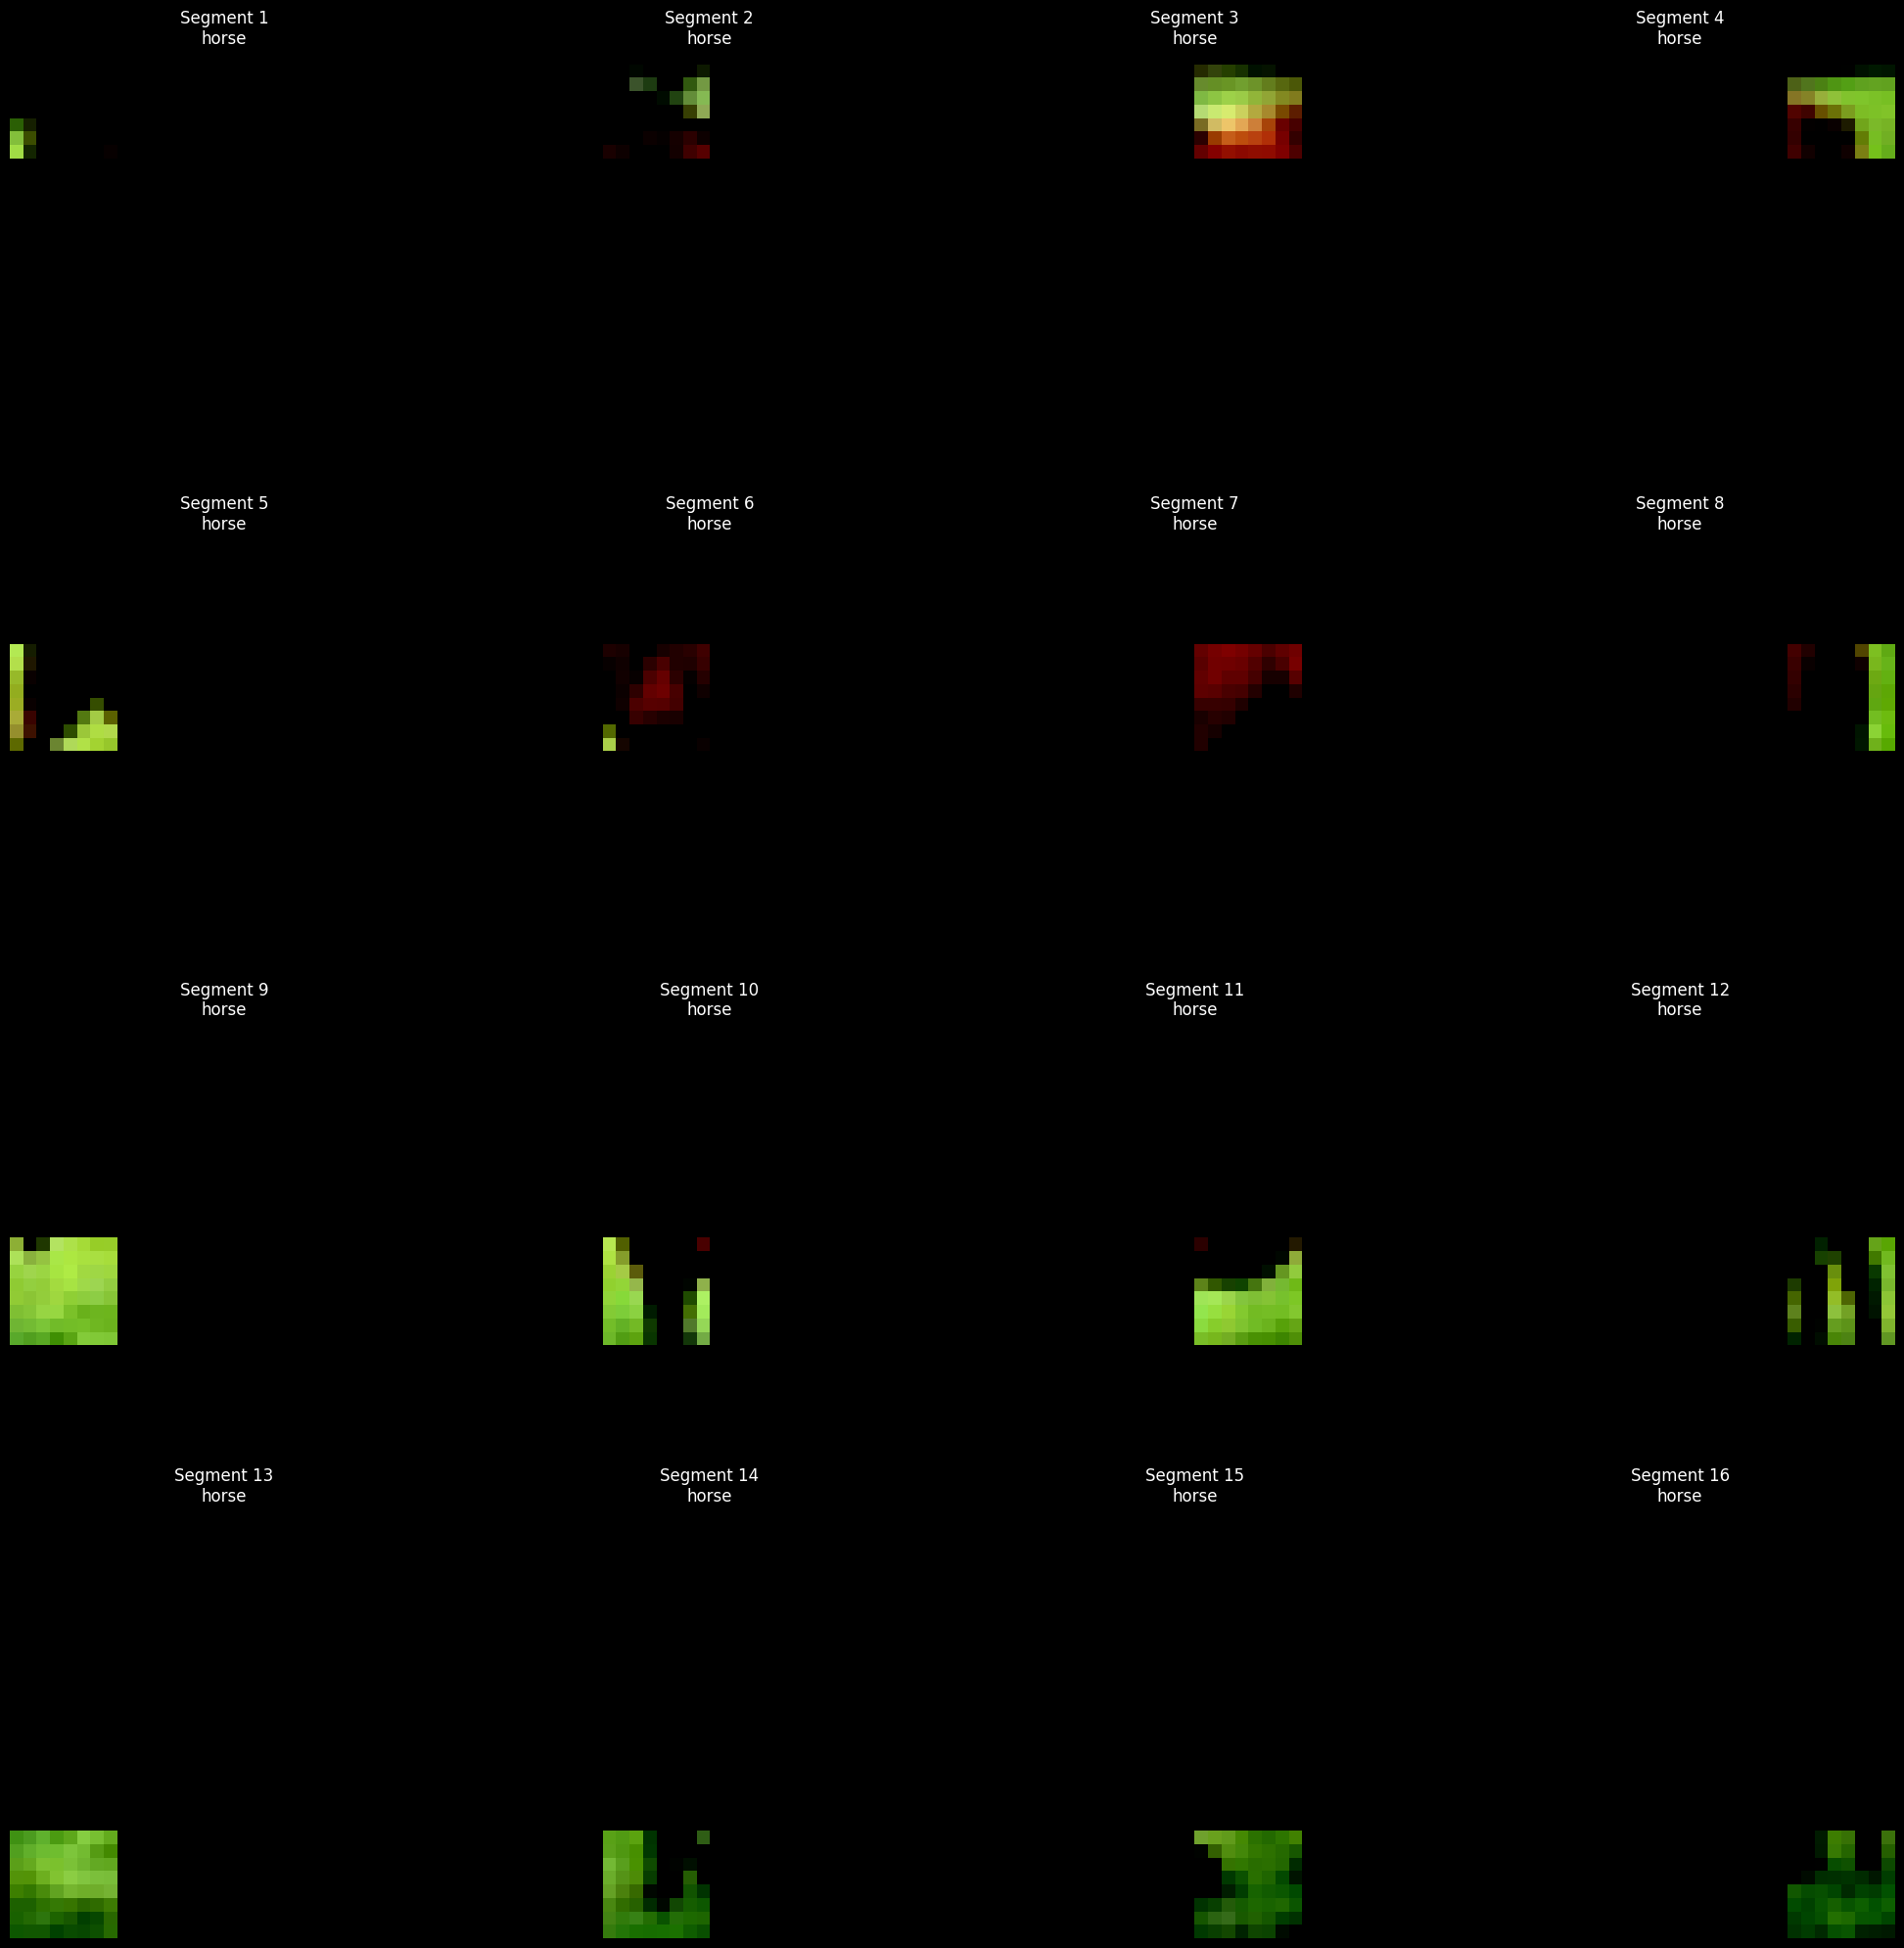

Files already downloaded and verified


KeyboardInterrupt: 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import copy

# Constants and global settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
ALL_HANDS_ON_DECK = 20
CIFAR10_CLASSES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def load_model(model_name):
    return torch.hub.load('pytorch/vision:v0.10.0', model_name, pretrained=False).to(DEVICE)

MODELS = [load_model(model_name) for model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']]

# Data Preprocessing and Visualization
class GridTransform:
    def __init__(self, row, col):
        self.row = row
        self.col = col

    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        blank = torch.zeros_like(tensor)
        slice_height, slice_width = tensor.shape[1] // 4, tensor.shape[2] // 4

        slices = (
            slice(None),
            slice(slice_height * self.row, slice_height * (self.row + 1)),
            slice(slice_width * self.col, slice_width * (self.col + 1)),
        )
        blank[slices] = tensor[slices]
        return (blank - 0.5) / 0.5

def create_transform(row, col):
    return transforms.Compose([GridTransform(row, col), transforms.Normalize((0.5,), (0.5,))])

def load_dataset(transform, train=True):
    return torchvision.datasets.CIFAR10(root="./data", train=train, download=True, transform=transform)

def create_loader(dataset):
    return torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

def show_example_images(loaders):
    images_list, labels_list = zip(*[(next(iter(loader))[0], next(iter(loader))[1]) for loader in loaders])
    idx = np.random.randint(0, len(images_list[0]))

    def denormalize(img):
        return img * 0.5 + 0.5

    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(denormalize(images_list[i][idx]).numpy().transpose(1, 2, 0))
        ax.set_title(f"Segment {i+1}\n{CIFAR10_CLASSES[labels_list[i][idx].item()]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Training and Testing Functions
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def train_model(model, loader, criterion, optimizer):
    model.train()
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()

def average_weights(models):
    avg_dict = {
        key: sum([model.state_dict()[key] for model in models]) / len(models)
        for key in models[0].state_dict().keys()
    }
    return avg_dict

def federated_learning(base_model, trainloaders, test_loader, criterion):
    models = [copy.deepcopy(base_model) for _ in trainloaders]
    optimizers = [optim.Adam(model.parameters(), lr=LEARNING_RATE) for model in models]
    history = []

    for model, loader in zip(models, trainloaders):
        train_model(model, loader, criterion, optimizers[models.index(model)])
        accuracy = test_model(model, test_loader)
        history.append(accuracy)

    avg_state_dict = average_weights(models)
    new_model = copy.deepcopy(base_model)
    new_model.load_state_dict(avg_state_dict)
    return new_model, history

# Main Execution
if __name__ == "__main__":
    # Load and transform data
    trainsets = [load_dataset(create_transform(row, col)) for row in range(4) for col in range(4)]
    trainloaders = [create_loader(trainset) for trainset in trainsets]
    show_example_images(trainloaders)

    testset = load_dataset(transform=create_transform(0, 0), train=False)
    test_loader = create_loader(testset)

    BASE_MODEL_HISTORY = {}

    for base_model in MODELS:
        criterion = nn.CrossEntropyLoss()
        model = copy.deepcopy(base_model)
        histories, avg_history = [[] for _ in range(16)], []

        for i in range(ALL_HANDS_ON_DECK):
            model, local_histories = federated_learning(model, trainloaders, test_loader, criterion)
            for h, local_h in zip(histories, local_histories):
                h.append(local_h)
            avg_history.append(test_model(model, test_loader))

        BASE_MODEL_HISTORY[base_model] = avg_history

    # Plotting
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, (model, history) in enumerate(BASE_MODEL_HISTORY.items()):
        axs[i].plot(history)
        axs[i].set_title(f"{model.__class__.__name__}")
        axs[i].set_xlabel("Iteration")
        axs[i].set_ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
